# Spam Filter with Quantum Optimization

E-mail spam filter. Classical ML which is optimized by a Quantum Approximation Optimization Algorithm.


# Classical realization
Used a classical ensemble of ML estimators  such as Random Foster, Boosting etc. 

The loss function of our ML algorithm has the form:

$$
\mathrm{argmin}_{w} \left(\frac{1}{N}\sum_{i=1}^{N}\left(\sum_{k=1}^{K}w_kh_k(x_i)-
y_i\right)^2+\lambda\|w\|_0\right),
$$

where $h_k(x_i)$ is the prediction of the weak estimator $k$ and $x_i$ are the data points. The weights $w_k$ are binary. The regularization in the $l_0$ norm ensures sparsity.

Expand the quadratic part:

$$
\mathrm{argmin}_{w} \left(\frac{1}{N}\sum_{i=1}^{N}
\left( \left(\sum_{k=1}^{K} w_k h_k(x_i)\right)^{2} -
2\sum_{k=1}^{K} w_k h_k(\mathbf{x}_i)y_i + y_i^{2}\right) + \lambda \|w\|_{0}
\right).
$$

Since $y_i^{2}$ is just a constant offset, the optimization reduces to

$$
\mathrm{argmin}_{w} \left(
\frac{1}{N}\sum_{k=1}^{K}\sum_{l=1}^{K} w_k w_l
\left(\sum_{i=1}^{N}h_k(x_i)h_l(x_i)\right) - 
\frac{2}{N}\sum_{k=1}^{K}w_k\sum_{i=1}^{N} h_k(x_i)y_i +
\lambda \|w\|_{0} \right).
$$

- $h_k(x_i)h_l(x_i)$: correlations between the predictions of the weak learners.

- $h_k(x_i)y_i$: correlation with the true label.



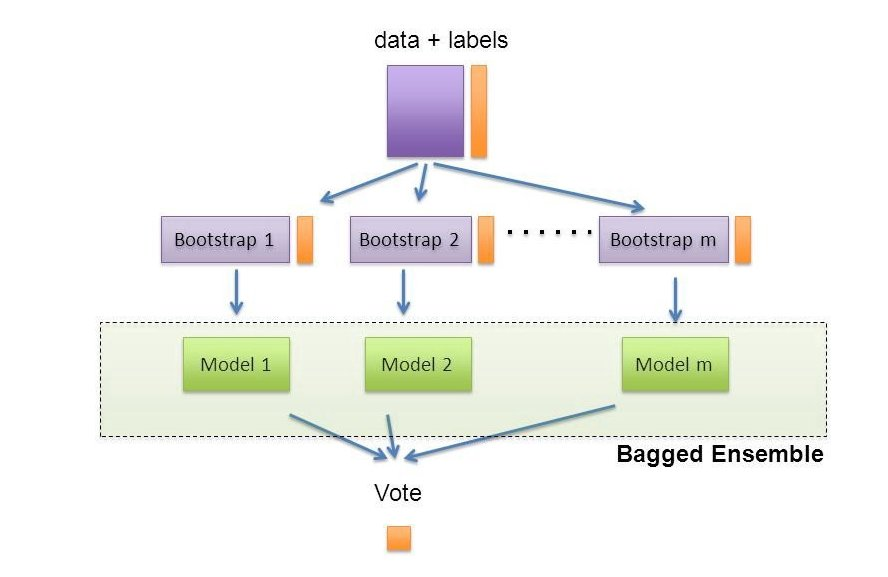

In [11]:
from IPython.display import Image
Image(filename='medium.comanalytics-vidhya.jpeg')

# Mapping loss function of an ensemble of models to the 1D Ising model Hamiltonian

The cost (loss) function of ML algorithms with binary weights can be written in a quadratic form:
$$
F(x)=\sum_{i,j} x_iA_{ij}x_j,\quad x\in \{0,1\}^n
$$
where x is a n-vector of binary variables, and $A$ is a $n\times n$ square symmetric matrix.


A loss function of this form can be mapped to the the Ising model Hamiltonian. Thereby the minimization of $F$ becomes a search of the ground state (i.e. minimum energy-eigenvalue). 

$$
 \hat{H}=-\sum_{<i,j>} J_{ij} \hat{\sigma}^Z_i \hat{\sigma}^Z_{j} - \sum_i h_i \hat{\sigma}^Z_i
$$


Also the *traverse 1D Ising model* can be used

$$
 \hat{H}=-\sum_{<i,j>} J_{ij} \hat{\sigma}^Z_i \hat{\sigma}^Z_{j} - \sum_i h_i \hat{\sigma}^Z_i - \sum_i g_i \hat{\sigma}^X_i
$$

The transverse field is important for the quantum approximation optimization algorithms. The $\sigma^X_i$ does not commute with the other terms. It becomes possible to exploit quantum effects like tunnelling [2]. 


# Minimization of the loss function using QAOA (Qiskit)
- Gets input of the free parameters of the $F$ and creates a Ising Hamiltonian from them
- The quantum alogirthm produces a ansatz (which depends on the specific algorithm implemented) that depends on $\theta_j$ parameters $|i(\theta_j)\rangle$
- Acts on the trial state with unitary transformations $M$ times.
$$
|\Psi(\theta_j)\rangle = \sum_{k=1}^{M} U_k(\theta_k) |i(\theta_j)\rangle
$$
- Calculates the expectation values $\langle|\Psi(\theta)|\hat{H}|\Psi(\theta)\rangle$
- Iterate and exploit quantum tunneling to find the eigenstate with the smallest energy
- Outputs the parameters which correspond to the ground state of $\hat{H}$ [1]. 


In [3]:
# Optimize Ising model

from qiskit.aqua import get_aer_backend, QuantumInstance
from qiskit.aqua.algorithms import QAOA
from qiskit.aqua.components.optimizers import COBYLA
p = 1
optimizer = COBYLA()
qaoa = QAOA(ising_model, optimizer, p, operator_mode='matrix')
backend = get_aer_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, shots=100)
result = qaoa.run(quantum_instance)

def predict(models, weights, X):

    n_data = X.shape[0]
    T = 0
    y = np.zeros(n_data)
    for i, h in enumerate(models):
        #print('type of predict')
        y0 = weights[i] * h.predict(X)  # prediction of weak classifier
        y += y0
        T += np.sum(y0)

    y = np.sign(y - T / (n_data*len(models)))

    return y

# Get optimized weights of estimators
k = np.argmin(result['eigvecs'][0])
weights = np.zeros(num_nodes)
for i in range(num_nodes):
    weights[i] = k % 2
    k >>= 1
    

/home/vasilis/anaconda3/lib/python3.7/site-packages/qiskit/aqua/operator.py:200: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/home/vasilis/anaconda3/lib/python3.7/site-packages/qiskit/aqua/operators/op_converter.py:92: DeprecationWarning: The `Operator` class is deprecated. Please use `WeightedPauliOperator` or `TPBGroupedWeightedPauliOperator` or `MatrixOperator` instead
  DeprecationWarning)
/home/vasilis/anaconda3/lib/python3.7/site-packages/qiskit/aqua/operator.py:200: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/home/vasilis/anaconda3/lib/python3.7/site-packages/qiskit/aqua/operator.py:

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import sklearn
import seaborn
metric = sklearn.metrics.accuracy_score


#Load data

data = pd.read_csv('spam.csv',encoding='latin-1')
data.loc[data['v1'].eq('ham'),'v1'] = 1
data.loc[data['v1'].eq('spam'),'v1'] = 0
data['v1']=data['v1'].astype('float64')


# Balance dataset
n = 747
sample_yes = data.ix[data.v1 == 1].sample(n=n, replace=False, random_state=0)
sample_no = data.ix[data.v1 == 0].sample(n=n, replace=False, random_state=0)
data = pd.concat([sample_yes, sample_no])
data = data.sample(frac=1).reset_index(drop=True)


train_data = data[:500]
test_data = data[500:]

#Vectorize the text

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data.v2)
y_train = train_data.v1

X_test = vectorizer.transform(test_data.v2)
y_test = test_data.v1

from sklearn.linear_model import Perceptron
model_1 = Perceptron(max_iter=1000, tol=1e-3)
model_1.fit(X_train, y_train)


model_2 = RandomForestClassifier(n_estimators=10, n_jobs=-1)
model_2.fit(X_train, y_train)


from sklearn.ensemble import AdaBoostClassifier
model_3 = AdaBoostClassifier(n_estimators=3)
model_3.fit(X_train, y_train)

# Define Ensemble

#ensemble = RandomForestClassifier(n_estimators=10, n_jobs=-1).fit(vectorized_text, train_data.v1)
ensemble = [model_1,model_2,model_3]
n_models = len(ensemble)

predictions = np.array([h.predict(X_train) for h in ensemble])
# scale hij to [-1/N, 1/N]
predictions =(predictions* 1/n_models)

λ = 1

# Define coeffitients

w = predictions @ predictions.T
wii = X_train.shape[0] / (n_models ** 2) + λ - 2 * predictions @ y_train
w[np.diag_indices_from(w)] = wii
W = {}
for i in range(n_models):
    for j in range(i, n_models):
        W[(i, j)] = w[i, j]
        
import dimod
#sampler = dimod.SimulatedAnnealingSampler()
#response = sampler.sample_qubo(W, num_reads=100)
#weights = list(response.first.sample.values())

# Create Ising model

h, J, offset = dimod.qubo_to_ising(W)
from qiskit.quantum_info import Pauli
from qiskit.aqua import Operator

num_nodes = len(w)
pauli_list = []
for i in range(num_nodes):
    wp = np.zeros(num_nodes)
    vp = np.zeros(num_nodes)
    vp[i] = 1
    pauli_list.append([h[i], Pauli(vp, wp)])
    for j in range(i+1, num_nodes):
        if w[i, j] != 0:
            wp = np.zeros(num_nodes)
            vp = np.zeros(num_nodes)
            vp[i] = 1
            vp[j] = 1
            pauli_list.append([J[i, j], Pauli(vp, wp)])
ising_model = Operator(paulis=pauli_list)

# Optimize Ising model

from qiskit.aqua import get_aer_backend, QuantumInstance
from qiskit.aqua.algorithms import QAOA
from qiskit.aqua.components.optimizers import COBYLA
p = 1
optimizer = COBYLA()
qaoa = QAOA(ising_model, optimizer, p, operator_mode='matrix')
backend = get_aer_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, shots=100)
result = qaoa.run(quantum_instance)

def predict(models, weights, X):

    n_data = X.shape[0]
    T = 0
    y = np.zeros(n_data)
    for i, h in enumerate(models):
        #print('type of predict')
        y0 = weights[i] * h.predict(X)  # prediction of weak classifier
        y += y0
        T += np.sum(y0)

    y = np.sign(y - T / (n_data*len(models)))

    return y

# Get optimized weights of estimators
k = np.argmin(result['eigvecs'][0])
weights = np.zeros(num_nodes)
for i in range(num_nodes):
    weights[i] = k % 2
    k >>= 1
    
#vectorized_test = vectorizer.transform(test_data.v2)
print('accuracy (test): %5.2f'%(metric( y_test, predict(ensemble, weights, X_test))))
print('accuracy (train): %5.2f'%(metric( y_train, predict(ensemble, weights, X_train))))
#print('accuracy (test): %5.2f'%(metric( test_data.v1, predict(ensemble, weights, vectorized_text))))

/home/vasilis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/vasilis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/vasilis/anaconda3/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/home/vasilis/anaconda3/lib/python3.7/site-packages/qiskit/aqua/ope

accuracy (test):  0.50
accuracy (train):  0.50


# Comments
- Data-set small ($\sim 500$ train)
- Small number of estimators (ensemble of 3 estimator). Stronger machine and longer training time is needed for more estimators, in order to have better inference.
- We transform text samples  to frequency of words which is sparse and have many zero elements. This can lead to some ty pe of numerical internal calculation.

# References 
[1] Training a Binary Classifier with the Quantum Adiabatic Algorithm, *Hartmut Neven, Vasil S. Denchev, Geordie Rose, William G. Macready*. (https://arxiv.org/abs/0811.0416).

[2] Ising model in a transverse field,*R. B. Stinchcombe*. Journal of Physics C: Solid State Physics, Volume 6, Number 15